<a href="https://colab.research.google.com/github/magomeda228/Colab_Google_ML_H-W/blob/main/Work_with_WineNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:

import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
wine_net = load_wine()
features =  13
#wine = wine.to(device)
X_train, X_test, y_train, y_test = train_test_split(
    wine_net.data[:, :features],
    wine_net.target,
    test_size=0.3,
    shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [23]:
class WineNet(torch.nn.Module):
    def __init__(self,n_input, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden_neurons)
        self.activ1=torch.nn.ReLU()
        self.fc2=torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.activ2=torch.nn.ReLU()
        self.fc3=torch.nn.Linear(n_hidden_neurons,3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [24]:
n_input =  13
batch_size = 10
hidden_neurons=[i for i in range(1,20)]
accuracy_hist={}

In [8]:
for n_hidden in hidden_neurons:
  wine_net=WineNet(features, n_hidden).to(device)
  optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)
  loss = torch.nn.CrossEntropyLoss()
# Переносим модель на устройство
  accuracy_hist[n_hidden] = []
  for epoch in range(200):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        # Перенос батча на устройство (например, GPU)
        x_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # Прямой проход
        preds = wine_net.forward(x_batch)

        # Вычисление ошибки
        loss_value = loss(preds, y_batch)

        # Обратное распространение ошибки
        loss_value.backward()

        # Обновление параметров
        optimizer.step()

    # Проверка каждые 10 эпох
    if epoch % 10 == 0:
        test_preds = wine_net.forward(X_test.to(device))
        test_preds = test_preds.argmax(dim=1)  # Убедитесь, что X_test на GPU
        accuracy = (test_preds == y_test).float().mean().item()
        accuracy_hist[n_hidden].append(accuracy)
    if epoch % 190 == 0:
        print(f"Epoch: {epoch}, Accuracy: {accuracy}, N_hidden: {n_hidden}")
        #print(f"Epoch: {epoch}, Accuracy: {accuracy}, N_hidden: {n_hidden}")
        # Перенос предсказаний и меток на CPU для анализа

#for n_hidden, acc in result:
 # print(f"Hidden neurons: {n_hidden}, Accuracy: {acc:.4f}")

Epoch: 0, Accuracy: 0.2777777910232544, N_hidden: 1
Epoch: 190, Accuracy: 0.6481481790542603, N_hidden: 1
Epoch: 0, Accuracy: 0.3333333432674408, N_hidden: 2
Epoch: 190, Accuracy: 0.6296296119689941, N_hidden: 2
Epoch: 0, Accuracy: 0.2777777910232544, N_hidden: 3
Epoch: 190, Accuracy: 0.3333333432674408, N_hidden: 3
Epoch: 0, Accuracy: 0.2777777910232544, N_hidden: 4
Epoch: 190, Accuracy: 0.7037037014961243, N_hidden: 4
Epoch: 0, Accuracy: 0.2777777910232544, N_hidden: 5
Epoch: 190, Accuracy: 0.8888888955116272, N_hidden: 5
Epoch: 0, Accuracy: 0.24074074625968933, N_hidden: 6
Epoch: 190, Accuracy: 0.8703703880310059, N_hidden: 6
Epoch: 0, Accuracy: 0.3333333432674408, N_hidden: 7
Epoch: 190, Accuracy: 0.8518518805503845, N_hidden: 7
Epoch: 0, Accuracy: 0.3333333432674408, N_hidden: 8
Epoch: 190, Accuracy: 0.8703703880310059, N_hidden: 8
Epoch: 0, Accuracy: 0.3333333432674408, N_hidden: 9
Epoch: 190, Accuracy: 0.7222222089767456, N_hidden: 9
Epoch: 0, Accuracy: 0.3333333432674408, N_hid

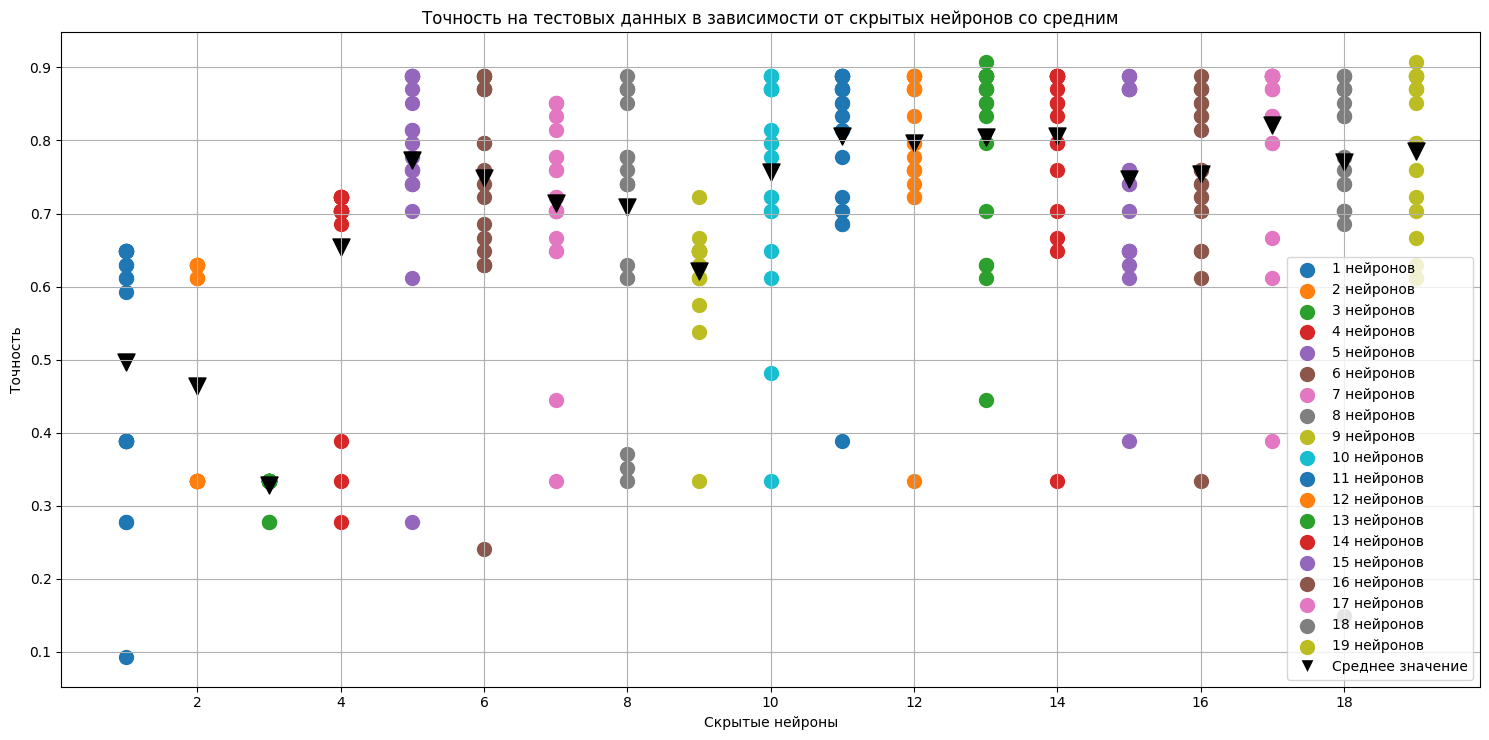

In [22]:
fig, ax = plt.subplots(figsize=(15, 7.5))
mean_ac = []
for n_hidden, accuracies in accuracy_hist.items():
  epoch=range(1, len(accuracies)+1)
  ax.scatter([n_hidden]*len(epoch), accuracies, label=f"{n_hidden} нейронов", s=100)
  mean_ac=sum(accuracies)/len(accuracies)
  ax.scatter(n_hidden,mean_ac, color='black', marker='v', s=150)

handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='black', markersize=10, label='Среднее значение'))
labels.append('Среднее значение')
plt.xlabel("Скрытые нейроны")
plt.ylabel("Точность")
plt.title("Точность на тестовых данных в зависимости от скрытых нейронов со средним")
plt.legend(handles=handles, labels=labels, loc='best')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.tight_layout()
plt.show()

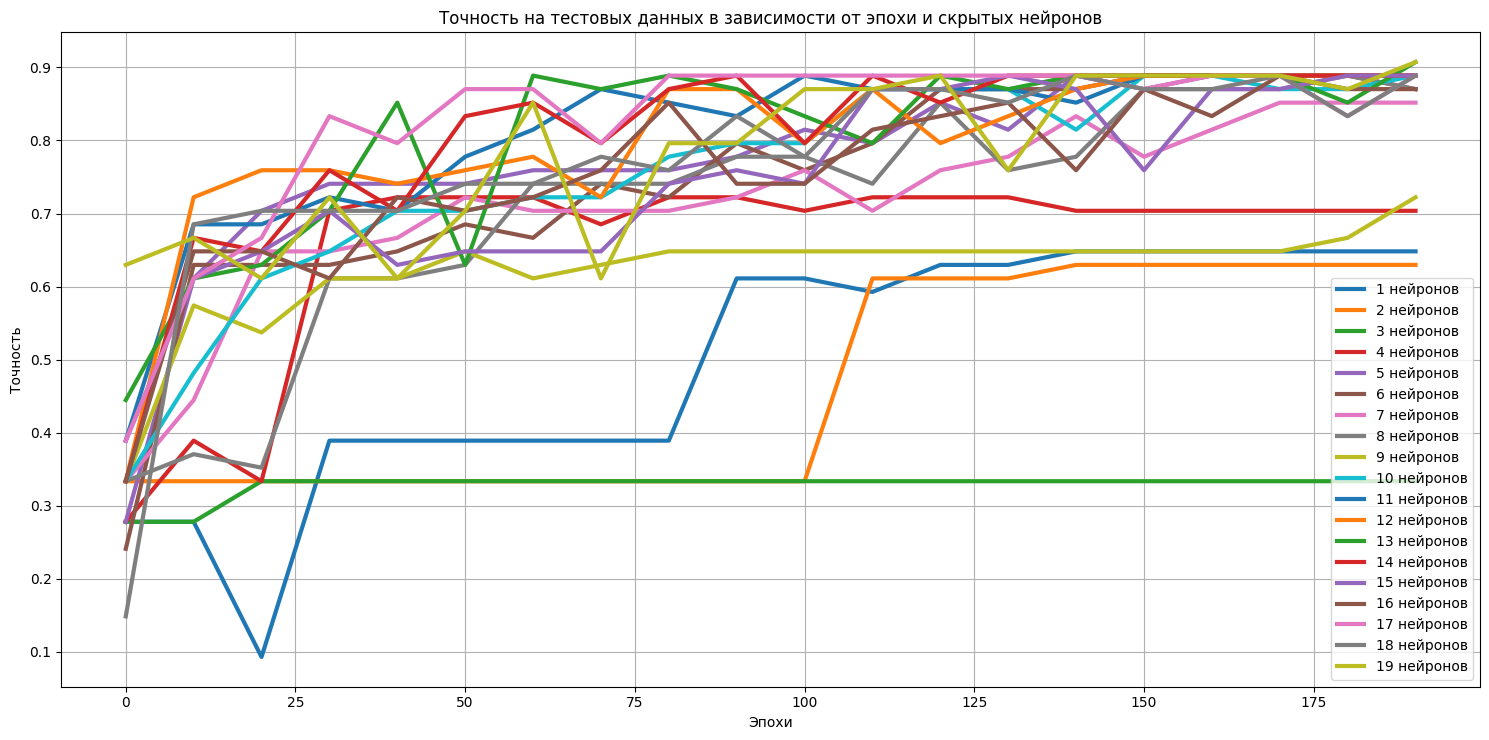

In [15]:
fig, ax = plt.subplots(figsize=(15, 7.5))
#mean_ac = []
#colors = plt.cm.viridis(np.linspace(0, 1, len(accuracy_hist)))
for n_hidden, accuracies in accuracy_hist.items():
  plt.plot(range(0, 10*(len(accuracies)),10), accuracies, label=f"{n_hidden} нейронов", linewidth=3)
  #ax.scatter(epoch,accuracies, color='black', marker='X', s=150)
plt.legend(markerfirst=False, markerscale=1.5)
#handles, labels = ax.get_legend_handles_labels()
#handles.append(plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10, label='Среднее значение'))
#labels.append('Среднее значение')

plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.title("Точность на тестовых данных в зависимости от эпохи и скрытых нейронов")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [56]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import torch
import numpy as np

wine_data = load_wine()
features =  13
n_input =  13
batch_size = 10
n_hidden = 10
accuracy_hist2={}
#wine = wine.to(device)

class WineNet(torch.nn.Module):
    def __init__(self,n_input, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden_neurons)
        self.activ1=torch.nn.ReLU()
        self.fc2=torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.activ2=torch.nn.ReLU()
        self.fc3=torch.nn.Linear(n_hidden_neurons,3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

for i in np.arange(0.1, 1.0, 0.05):
    X_train, X_test, y_train, y_test = train_test_split(
     wine_data.data[:, :features],
     wine_data.target,
     test_size=i,
     shuffle=True
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_train = torch.FloatTensor(X_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    y_test = torch.LongTensor(y_test).to(device)

    wine_net = WineNet(features, n_hidden).to(device)
    optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)
    loss = torch.nn.CrossEntropyLoss()
    # Переносим модель на устройство
    accuracy_hist2[i] = []

    for epoch in range(200):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]

            # Перенос батча на устройство (например, GPU)
            x_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            # Прямой проход
            preds = wine_net.forward(x_batch)

            # Вычисление ошибки
            loss_value = loss(preds, y_batch)

            # Обратное распространение ошибки
            loss_value.backward()

            # Обновление параметров
            optimizer.step()

        # Проверка каждые 10 эпох
        if epoch % 10 == 0:
            test_preds = wine_net.forward(X_test.to(device))
            test_preds = test_preds.argmax(dim=1)  # Убедитесь, что X_test на GPU
            accuracy = (test_preds == y_test).float().mean().item()
            accuracy_hist2[i].append(accuracy)

        if epoch % 190 == 0:
           print(f"Epoch: {epoch}, Accuracy: {accuracy}, test_size: {i:.2f}")
            #print(f"Epoch: {epoch}, Accuracy: {accuracy}, N_hidden: {n_hidden}")
            # Перенос предсказаний и меток на CPU для анализа

    #for n_hidden, acc in result:
    # print(f"Hidden neurons: {n_hidden}, Accuracy: {acc:.4f}")

Epoch: 0, Accuracy: 0.3888888955116272, test_size: 0.10
Epoch: 190, Accuracy: 0.8333333134651184, test_size: 0.10
Epoch: 0, Accuracy: 0.5185185074806213, test_size: 0.15
Epoch: 190, Accuracy: 0.7037037014961243, test_size: 0.15
Epoch: 0, Accuracy: 0.3611111044883728, test_size: 0.20
Epoch: 190, Accuracy: 0.944444477558136, test_size: 0.20
Epoch: 0, Accuracy: 0.2888889014720917, test_size: 0.25
Epoch: 190, Accuracy: 0.9333333373069763, test_size: 0.25
Epoch: 0, Accuracy: 0.2222222238779068, test_size: 0.30
Epoch: 190, Accuracy: 0.9259259104728699, test_size: 0.30
Epoch: 0, Accuracy: 0.3968254327774048, test_size: 0.35
Epoch: 190, Accuracy: 0.8730159401893616, test_size: 0.35
Epoch: 0, Accuracy: 0.3055555522441864, test_size: 0.40
Epoch: 190, Accuracy: 0.7083333134651184, test_size: 0.40
Epoch: 0, Accuracy: 0.395061731338501, test_size: 0.45
Epoch: 190, Accuracy: 0.9259259104728699, test_size: 0.45
Epoch: 0, Accuracy: 0.42222222685813904, test_size: 0.50
Epoch: 190, Accuracy: 0.966666698

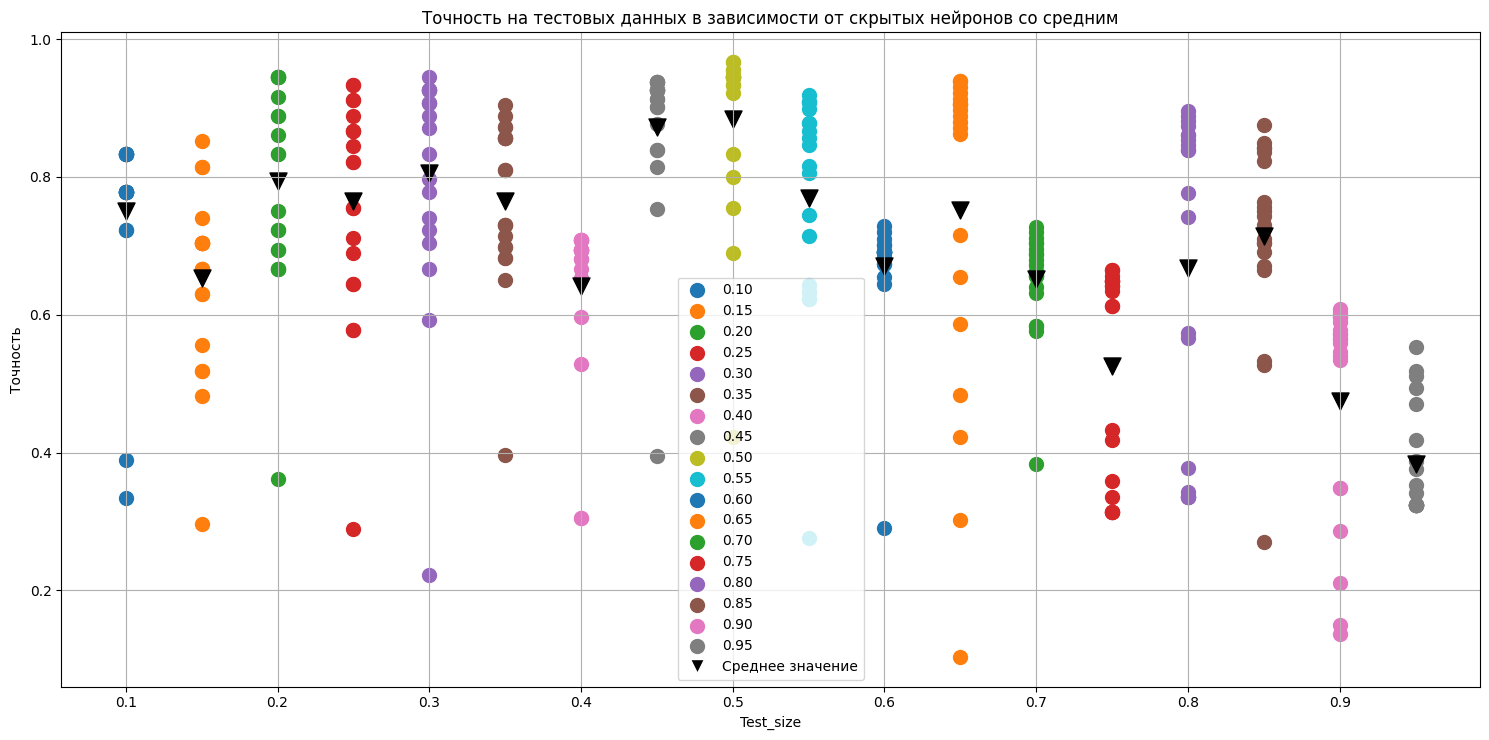

In [59]:
fig, ax = plt.subplots(figsize=(15, 7.5))
mean_ac = []
for test_size, accuracies in accuracy_hist2.items():
  epoch=range(1, len(accuracies)+1)
  ax.scatter([test_size]*len(epoch), accuracies, label=f"{test_size:.2f}", s=100)
  mean_ac=sum(accuracies)/len(accuracies)
  ax.scatter(test_size,mean_ac, color='black', marker='v', s=150)

handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='black', markersize=10, label='Среднее значение'))
labels.append('Среднее значение')
plt.xlabel("Test_size")
plt.ylabel("Точность")
plt.title("Точность на тестовых данных в зависимости от скрытых нейронов со средним")
plt.legend(handles=handles, labels=labels, loc='best')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.tight_layout()
plt.show()

In [67]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import time

wine_data = load_wine()
features =  13
n_input =  13
n_hidden = 10
accuracy_hist3={}
#wine = wine.to(device)

class WineNet(torch.nn.Module):
    def __init__(self,n_input, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden_neurons)
        self.activ1=torch.nn.ReLU()
        self.fc2=torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.activ2=torch.nn.ReLU()
        self.fc3=torch.nn.Linear(n_hidden_neurons,3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

X_train, X_test, y_train, y_test = train_test_split(
     wine_data.data[:, :features],
     wine_data.target,
     test_size=0.3,
     shuffle=True
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

wine_net = WineNet(features, n_hidden).to(device)
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)
loss = torch.nn.CrossEntropyLoss()
    # Переносим модель на устройство
time_hist = []
for batch_size in range(10,200,10):
  start_time = time.perf_counter()
  for epoch in range(200):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]

            # Перенос батча на устройство (например, GPU)
            x_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            # Прямой проход
            preds = wine_net.forward(x_batch)

            # Вычисление ошибки
            loss_value = loss(preds, y_batch)

            # Обратное распространение ошибки
            loss_value.backward()

            # Обновление параметров
            optimizer.step()

        # Проверка каждые 10 эпох
        if epoch % 10 == 0:
            test_preds = wine_net.forward(X_test.to(device))
            test_preds = test_preds.argmax(dim=1)  # Убедитесь, что X_test на GPU
            accuracy = (test_preds == y_test).float().mean().item()
            #accuracy_hist3[test_size].append(accuracy)
        end_time = time.perf_counter()
        if epoch==190:
           end_time = time.perf_counter()
           time_hist.append(end_time - start_time)
           print(f"Epoch: {epoch}, time: {end_time - start_time}, batch_size: {batch_size}")
           #print(f"Epoch: {epoch}, Accuracy: {accuracy}, N_hidden: {n_hidden}")
            # Перенос предсказаний и меток на CPU для анализа

    #for n_hidden, acc in result:
    # print(f"Hidden neurons: {n_hidden}, Accuracy: {acc:.4f}")

Epoch: 190, time: 4.082825090999904, batch_size: 10
Epoch: 190, time: 2.0524418160002824, batch_size: 20
Epoch: 190, time: 1.3978988889998618, batch_size: 30
Epoch: 190, time: 1.1010029720000603, batch_size: 40
Epoch: 190, time: 0.8399192420001782, batch_size: 50
Epoch: 190, time: 0.8518543840000348, batch_size: 60
Epoch: 190, time: 0.580405963999965, batch_size: 70
Epoch: 190, time: 0.5728380059999836, batch_size: 80
Epoch: 190, time: 0.571235262999835, batch_size: 90
Epoch: 190, time: 0.5653324039999461, batch_size: 100
Epoch: 190, time: 0.5680057320000742, batch_size: 110
Epoch: 190, time: 0.5661893490000693, batch_size: 120
Epoch: 190, time: 0.3006574390001333, batch_size: 130
Epoch: 190, time: 0.3770593019999069, batch_size: 140
Epoch: 190, time: 0.359027882999726, batch_size: 150
Epoch: 190, time: 0.35409258999970916, batch_size: 160
Epoch: 190, time: 0.3784957249999934, batch_size: 170
Epoch: 190, time: 0.38976817499997196, batch_size: 180
Epoch: 190, time: 0.41120890499996676, 

In [68]:
print(time_hist)

[4.082825090999904, 2.0524418160002824, 1.3978988889998618, 1.1010029720000603, 0.8399192420001782, 0.8518543840000348, 0.580405963999965, 0.5728380059999836, 0.571235262999835, 0.5653324039999461, 0.5680057320000742, 0.5661893490000693, 0.3006574390001333, 0.3770593019999069, 0.359027882999726, 0.35409258999970916, 0.3784957249999934, 0.38976817499997196, 0.41120890499996676]


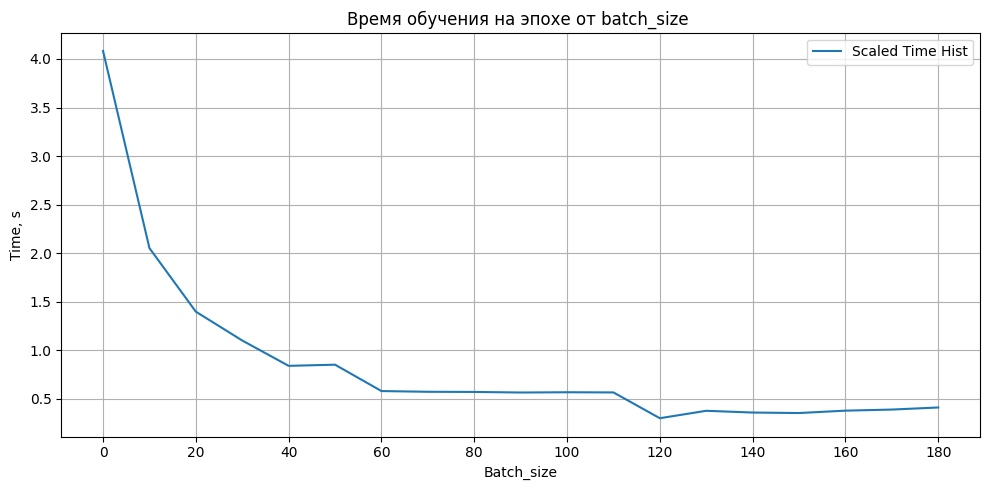

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(10 * np.array(range(len(time_hist))), time_hist, label='Scaled Time Hist')

plt.xlabel("Batch_size")
plt.ylabel("Time, s")
plt.title("Время обучения на эпохе от batch_size ")
plt.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.tight_layout()
plt.show()